In [ ]:
"""
Zhiwei's original script that attempts to do the direct connectivity plots

"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools 
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy import stats
import datajoint as dj
from collections import defaultdict
import pycircstat as pycs
from funconnect import morphology, connectomics, ta3, nda
from tqdm import tqdm
import scipy.stats as stats


Connecting zhiwei@10.28.0.34:3306


In [2]:
ta3p100 = dj.create_virtual_module('microns_ta3p100', 'microns_ta3p100')
ndap100 = dj.create_virtual_module('microns_ndap100', 'microns_ndap100')
radtune = dj.create_virtual_module('goldfunc_radtune', 'goldfunc_radtune')
spattune = dj.create_virtual_module('goldfunc_spattune', 'goldfunc_spattune')
fc = dj.create_virtual_module('fc', 'goldfunc_fc')


# Direct Connection

## Orientation / direction tuning 

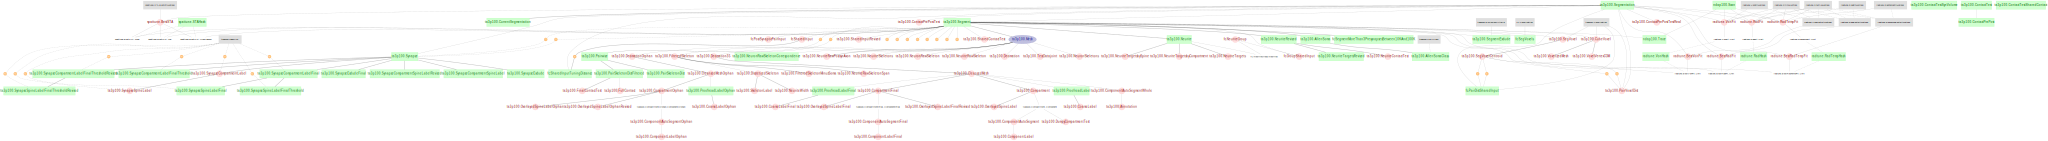

In [3]:
dj.ERD(ta3p100) +1 -1

In [93]:
# Exclude synapses, segments and restrict by functional confidence 

synapse = (ta3p100.Synapse - ta3p100.SynapseExcludeFinal) & ta3p100.CurrentSegmentation
segment = (ta3p100.Segment - ta3p100.SegmentExclude) & ta3p100.CurrentSegmentation
soma = (ta3p100.AllenSoma - ta3p100.SegmentExclude) & ta3p100.CurrentSegmentation

In [94]:
# number of direct connections (synapses) for each functional soma pair (both presyn and postsyn are somas with functional traces)

fun_fun_syn = synapse & soma.proj(presyn = 'segment_id') & soma.proj(postsyn = 'segment_id') 
n_syn = dj.U('presyn', 'postsyn').aggr(fun_fun_syn, n_syn = 'count(*)') # soma-soma pairs with at least one synapse

all_fun_fun = soma.proj(presyn = 'segment_id') * soma.proj(postsyn = 'segment_id') & 'presyn != postsyn'
rel = (dj.U('presyn', 'postsyn') & all_fun_fun).proj('presyn', 'postsyn', n_syn='0')
total_n_syn = rel.aggr(dj.U('n_add') * n_syn.proj(n_add='n_syn'), n_syn_total='n_syn + ifnull(n_add, 0)', keep_all_rows=True)# fill out all zeros

#reciprocal_pairs = (n_syn * n_syn.proj(postsyn='presyn', presyn='postsyn', n_syn_2='n_syn')).proj(n_syn = 'n_syn + n_syn_2')



In [101]:
total_n_syn

presyn segment id unique within each Segmentation,postsyn segment id unique within each Segmentation,n_syn_total calculated attribute
648518346341366885,648518346341371119,0
648518346341366885,648518346341382424,0
648518346341366885,648518346341388820,0
648518346341366885,648518346341393609,0
648518346341366885,648518346341394877,0
648518346341366885,648518346342018870,0
648518346341366885,648518346342162152,0


## Should count undirected soma-soma pairs, i.e. A->B and B->A synpases summed together for connection between A and B


In [95]:
# combine a-b and b-a connections into one number, and segment_id1 < segment_id2
attrs = ['presyn', 'postsyn', 'n_syn_total']
a = (total_n_syn & 'presyn < postsyn').proj('presyn', 'postsyn', n_syn1 = 'n_syn_total')
b = (total_n_syn & 'presyn > postsyn').proj(n_syn2 = 'n_syn_total', postsyn = 'presyn', presyn = 'postsyn')
undirected_n_syn = (a * b).proj(n_syn_total = 'n_syn1 + n_syn2', segment_id1 = 'presyn', segment_id2 = 'postsyn')


In [118]:
# functional metrics for each functional soma pair (restricting by radtune fitting significance)

tuned = 'confidence > 0.5'
sig_units = radtune.BestVonFit.Unit & 'von_p_value <= 0.001' & tuned
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                 sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

radconn_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * undirected_n_syn).fetch())

'''
# dataframe for directed connections, i.e. a-b different from b-a

attrs = ['von_hash1', 'von_hash2', 'segmentation', 'segment_id1', 'segment_id2', 'diff_pref_ori', 'diff_pref_dir', 'diff_sharp', 'diff_osi', 'diff_dsi', 'von_corr', 'von_corr_pvalue', 'diff_v_adv', 'diff_v_pvalue']

radconn_pairs1 = (radtune.BestVonCorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id1', postsyn = 'segment_id2') * total_n_syn
radconn_pairs2 = (radtune.BestVonCorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id2', postsyn = 'segment_id1') * total_n_syn

radconn_df1 = pd.DataFrame(radconn_pairs1.fetch())
radconn_df2 = pd.DataFrame(radconn_pairs2.fetch())
radconn_df = pd.concat([radconn_df1, radconn_df2], ignore_index=True)
'''


"\n# dataframe for directed connections, i.e. a-b different from b-a\n\nattrs = ['von_hash1', 'von_hash2', 'segmentation', 'segment_id1', 'segment_id2', 'diff_pref_ori', 'diff_pref_dir', 'diff_sharp', 'diff_osi', 'diff_dsi', 'von_corr', 'von_corr_pvalue', 'diff_v_adv', 'diff_v_pvalue']\n\nradconn_pairs1 = (radtune.BestVonCorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id1', postsyn = 'segment_id2') * total_n_syn\nradconn_pairs2 = (radtune.BestVonCorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id2', postsyn = 'segment_id1') * total_n_syn\n\nradconn_df1 = pd.DataFrame(radconn_pairs1.fetch())\nradconn_df2 = pd.DataFrame(radconn_pairs2.fetch())\nradconn_df = pd.concat([radconn_df1, radconn_df2], ignore_index=True)\n"

In [119]:
sum(radconn_df['n_syn_total'].values)

50

In [130]:
radconn_df['n_syn_total'].values

array([0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [121]:
# set up bins for difference in preferred direction
rad2deg = 180/np.pi
dir_edges = np.linspace(0, np.pi, 5)
de = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in dir_edges]])
dir_labels = list(zip(de[:-1], de[1:]))
dir_centers = np.round((dir_edges[1:] + dir_edges[:-1])/2 * rad2deg, decimals=2) 

In [122]:
# set up bins for difference in prefered orientation 
ori_edges = np.linspace(0, np.pi /2 ,5)
oe = list(['{:.0f}'.format(ee) for ee in [np.round(e * rad2deg) for e in ori_edges]])
ori_labels = list(zip(oe[:-1], oe[1:]))
ori_centers = np.round((ori_edges[1:] + ori_edges[:-1])/2 * rad2deg, decimals=2) 

In [123]:
# set up bins for difference in tuning sharpness
sharp_edges = np.linspace(min(np.abs(radconn_df['diff_sharp'])), max(np.abs(radconn_df['diff_sharp'])), 6)
se = list(['{:.1f}'.format(ee) for ee in sharp_edges])
sharp_labels = list(zip(se[:-1], se[1:]))
sharp_centers = np.hstack((np.nan, np.round((sharp_edges[1:] + sharp_edges[:-1])/2, decimals=2), np.nan))

In [124]:
# bin diff_pref_ori, diff_pref_dir, diff_sharp
radconn_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radconn_df['diff_pref_ori']), ori_edges)) - 1]
radconn_df['bin_diff_pref_dir'] = dir_centers[(np.digitize(np.abs(radconn_df['diff_pref_dir']), dir_edges)) - 1]
radconn_df['bin_diff_sharp'] = sharp_centers[(np.digitize(np.abs(radconn_df['diff_sharp']), sharp_edges))]

In [125]:
# convert n_syn_total into binary values
radconn_df['n_syn_binary'] = 1 * (radconn_df['n_syn_total'] > 0).values
radconn_df_part = radconn_df[radconn_df['n_syn_total'] > 0]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


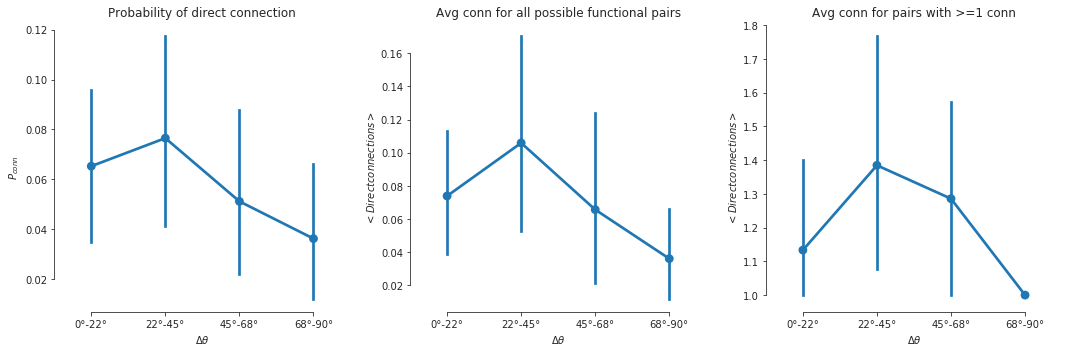

In [126]:
# for difference in preferred orientation 

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_pref_ori', 'n_syn_binary', data = radconn_df, ax=ax[0]) # probability of direct connection
sns.pointplot('bin_diff_pref_ori', 'n_syn_total', data = radconn_df, ax=ax[1])  # average number of connections for all possible functional pairs
sns.pointplot('bin_diff_pref_ori', 'n_syn_total', data = radconn_df_part, ax=ax[2]) # average number of connections for pairs with at least one direct connection

ax[0].set_title('Probability of direct connection')
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[0].set_xlabel(r'$\Delta \theta$')
ax[0].set_ylabel('$P_{conn}$')

ax[1].set_title('Avg conn for all possible functional pairs')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[1].set_xlabel(r'$\Delta \theta$')
ax[1].set_ylabel('$<Direct connections>$')

ax[2].set_title('Avg conn for pairs with >=1 conn')
ax[2].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[2].set_xlabel(r'$\Delta \theta$')
ax[2].set_ylabel('$<Direct connections>$')

sns.despine(trim=True)
fig.tight_layout()



/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


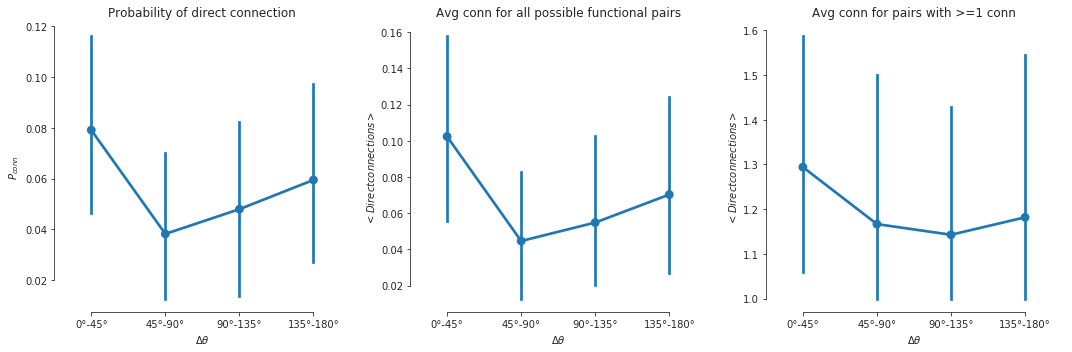

In [127]:
# for difference in preferred direction 

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_pref_dir', 'n_syn_binary', data = radconn_df, ax=ax[0]) # probability of direct connection
sns.pointplot('bin_diff_pref_dir', 'n_syn_total', data = radconn_df, ax=ax[1])  # average number of connections for all possible functional pairs
sns.pointplot('bin_diff_pref_dir', 'n_syn_total', data = radconn_df_part, ax=ax[2]) # average number of connections for pairs with at least one direct connection

ax[0].set_title('Probability of direct connection')
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[0].set_xlabel(r'$\Delta \theta$')
ax[0].set_ylabel('$P_{conn}$')

ax[1].set_title('Avg conn for all possible functional pairs')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[1].set_xlabel(r'$\Delta \theta$')
ax[1].set_ylabel('$<Direct connections>$')

ax[2].set_title('Avg conn for pairs with >=1 conn')
ax[2].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[2].set_xlabel(r'$\Delta \theta$')
ax[2].set_ylabel('$<Direct connections>$')

sns.despine(trim=True)
fig.tight_layout()


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


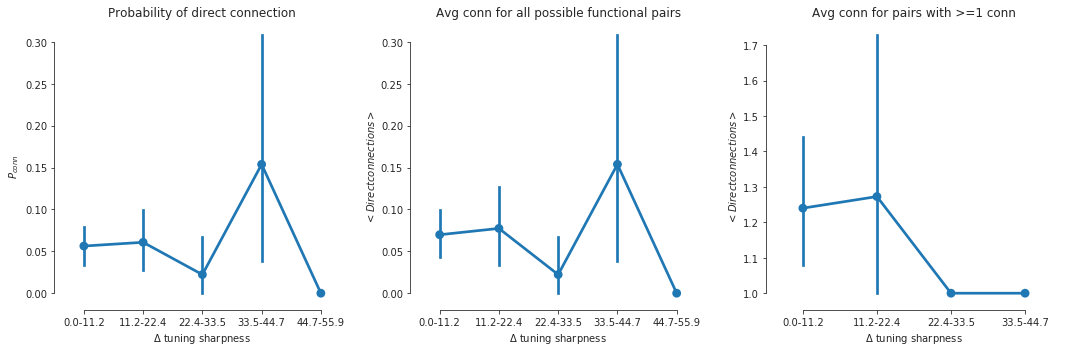

In [128]:
# for difference in tuning sharpness

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_sharp', 'n_syn_binary', data = radconn_df, ax=ax[0]) # probability of direct connection
sns.pointplot('bin_diff_sharp', 'n_syn_total', data = radconn_df, ax=ax[1])  # average number of connections for all possible functional pairs
sns.pointplot('bin_diff_sharp', 'n_syn_total', data = radconn_df_part, ax=ax[2]) # average number of connections for pairs with at least one direct connection

ax[0].set_title('Probability of direct connection')
ax[0].set_xticklabels(['{}-{}'.format(*a) for a in sharp_labels])
ax[0].set_xlabel(r'$\Delta$ tuning sharpness')
ax[0].set_ylabel('$P_{conn}$')

ax[1].set_title('Avg conn for all possible functional pairs')
ax[1].set_xticklabels(['{}-{}'.format(*a) for a in sharp_labels])
ax[1].set_xlabel(r'$\Delta$ tuning sharpness')
ax[1].set_ylabel('$<Direct connections>$')

ax[2].set_title('Avg conn for pairs with >=1 conn')
ax[2].set_xticklabels(['{}-{}'.format(*a) for a in sharp_labels])
ax[2].set_xlabel(r'$\Delta$ tuning sharpness')
ax[2].set_ylabel('$<Direct connections>$')

sns.despine(trim=True)
fig.tight_layout()


## Receptive field

In [116]:
# functional metrics for each functional soma pair (restricting by spattune fitting significance)


sig_units = spattune.BestSTA.Loc & 'sta_snr > 1.5' & segment
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                  sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

spatconn_df = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs) * undirected_n_syn).fetch())

'''
# dataframe for directed connections, i.e. a-b different from b-a

attrs = ['sta_hash1', 'sta_hash2', 'apert_radius', 'segmentation', 'segment_id1', 'segment_id2', 'center_dist', 'apert_overlap', 'full_corr_r2', 'full_corr_pvalue', 
         'union_corr_r2', 'union_corr_pvalue', 'intersect_corr_r2', 'intersect_corr_pvalue', 'align_corr_r2', 'align_corr_pvalue', 'align_overlap', 'diff_snr', 'diff_snr_pvalue']

spatconn_pairs1 = (spattune.BestSTACorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id1', postsyn = 'segment_id2') * total_n_syn
spatconn_pairs2 = (spattune.BestSTACorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id2', postsyn = 'segment_id1') * total_n_syn

spatconn_df1 = pd.DataFrame(spatconn_pairs1.fetch())
spatconn_df2 = pd.DataFrame(spatconn_pairs2.fetch())
spatconn_df = pd.concat([spatconn_df1, spatconn_df2])
'''


"\n# dataframe for directed connections, i.e. a-b different from b-a\n\nattrs = ['sta_hash1', 'sta_hash2', 'apert_radius', 'segmentation', 'segment_id1', 'segment_id2', 'center_dist', 'apert_overlap', 'full_corr_r2', 'full_corr_pvalue', \n         'union_corr_r2', 'union_corr_pvalue', 'intersect_corr_r2', 'intersect_corr_pvalue', 'align_corr_r2', 'align_corr_pvalue', 'align_overlap', 'diff_snr', 'diff_snr_pvalue']\n\nspatconn_pairs1 = (spattune.BestSTACorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id1', postsyn = 'segment_id2') * total_n_syn\nspatconn_pairs2 = (spattune.BestSTACorr & sig_unit_pairs).proj(*attrs, presyn = 'segment_id2', postsyn = 'segment_id1') * total_n_syn\n\nspatconn_df1 = pd.DataFrame(spatconn_pairs1.fetch())\nspatconn_df2 = pd.DataFrame(spatconn_pairs2.fetch())\nspatconn_df = pd.concat([spatconn_df1, spatconn_df2])\n"

In [117]:
spatconn_df

,sta_hash1,sta_hash2,apert_radius,segmentation,segment_id1,segment_id2,center_dist,apert_overlap,full_corr_r2,full_corr_pvalue,union_corr_r2,union_corr_pvalue,intersect_corr_r2,intersect_corr_pvalue,align_corr_r2,align_corr_pvalue,align_overlap,diff_snr,diff_snr_pvalue,n_syn_total
0,83af7554273be6cde38d0c4a12f10331,6987cef946e99bf5655cd229ae3ba57f,20,2,648518346349470171,648518346349471565,17.46420,0.455183,-0.011687,1.608110e-01,-0.020126,3.783440e-01,-0.034542,4.096200e-01,-0.132671,2.635950e-06,0.99074,-0.07754,0.0,0
1,83af7554273be6cde38d0c4a12f10331,7b64aa0b8e0beee0732b42557cf56fae,20,2,648518346349470171,648518346349472601,3.61256,0.877739,0.125530,0.000000e+00,0.310254,1.661340e-32,0.334353,3.243750e-30,-0.046115,1.038710e-01,0.99074,0.00717,0.0,0
2,83af7554273be6cde38d0c4a12f10331,f0983f1e1d997b339bafcacf4a7d5d8d,20,2,648518346349470171,648518346349473781,7.21110,0.763148,-0.002783,7.384360e-01,-0.162260,1.702020e-10,-0.175755,4.293810e-08,-0.122724,1.409810e-05,0.99074,-0.03169,0.0,0
3,83af7554273be6cde38d0c4a12f10331,b62252b1f8d2f6dcaeb78c9cb047affd,20,2,648518346349470171,648518346349473808,3.82172,0.876944,-0.036044,1.516450e-05,-0.070898,7.805410e-03,-0.070466,1.931120e-02,-0.143718,3.535760e-07,0.99074,0.58678,0.0,0
4,83af7554273be6cde38d0c4a12f10331,00c38ffd77cd45bd7bfa91451f96769a,20,2,648518346349470171,648518346349473813,4.56217,0.850683,-0.043669,1.585590e-07,-0.206468,3.053530e-15,-0.218972,4.518200e-13,-0.107254,1.497090e-04,0.99074,-0.13741,0.0,2
5,83af7554273be6cde38d0c4a12f10331,bd6583a7852c392cca2717f7f0243ce4,20,2,648518346349470171,648518346349475138,19.19330,0.413803,-0.092373,1.152890e-28,-0.158243,1.284990e-12,-0.184405,2.323540e-05,0.285104,1.030120e-24,0.99074,-0.20571,0.0,0
6,83af7554273be6cde38d0c4a12f10331,734ac75857b47c2b50ffdfc616c9ec92,20,2,648518346349470171,648518346349475425,9.21954,0.701873,-0.095222,2.307330e-30,-0.152510,7.902180e-10,-0.156948,2.819250e-06,-0.223318,1.553230e-15,0.99074,0.16659,0.0,0
7,83af7554273be6cde38d0c4a12f10331,eb3665c7bda70605d840c9b945deff1d,20,2,648518346349470171,648518346349475510,4.37683,0.858641,0.075027,1.966360e-19,0.327795,5.096610e-37,0.341094,8.375760e-31,0.297344,7.802010e-27,0.99074,-0.22958,0.0,0
8,83af7554273be6cde38d0c4a12f10331,adef2e27eb7ecd2a4e2bdd53fe30b5b1,20,2,648518346349470171,648518346349475520,5.25752,0.829197,0.051878,4.692440e-10,0.227110,1.398650e-18,0.258331,2.388650e-17,0.527820,0.000000e+00,0.99074,0.72605,0.0,0
9,83af7554273be6cde38d0c4a12f10331,f89a79514ec2577a641a2340c94bfe3d,20,2,648518346349470171,648518346349475521,7.83366,0.748028,0.088749,1.405350e-26,0.191579,2.233880e-14,0.208900,9.949280e-11,-0.108741,1.208250e-04,0.99074,-0.23910,0.0,0


In [27]:
# set up bins for `union_corr_r2`
union_edges = np.linspace(min(spatconn_df['union_corr_r2']), max(spatconn_df['union_corr_r2']), 6)
ue = list(['{:.2f}'.format(ee) for ee in union_edges])
union_labels = list(zip(ue[:-1], ue[1:]))
union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))

In [28]:
# bin `union_corr_r2`
spatconn_df['bin_union_corr_r2'] = union_centers[(np.digitize(spatconn_df['union_corr_r2'], union_edges))]


In [29]:
# convert n_syn_total into binary values
spatconn_df['n_syn_binary'] = 1 * (spatconn_df['n_syn_total'] > 0).values
spatconn_df_part = spatconn_df[spatconn_df['n_syn_total'] > 0]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


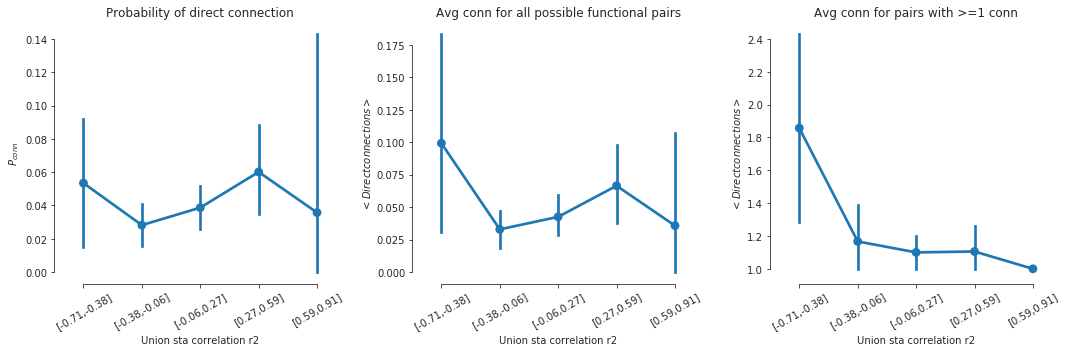

In [30]:
# for difference in preferred orientation 

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_union_corr_r2', 'n_syn_binary', data = spatconn_df, ax=ax[0]) # probability of direct connection
sns.pointplot('bin_union_corr_r2', 'n_syn_total', data = spatconn_df, ax=ax[1])  # average number of connections for all possible functional pairs
sns.pointplot('bin_union_corr_r2', 'n_syn_total', data = spatconn_df_part, ax=ax[2]) # average number of connections for pairs with at least one direct connection

ax[0].set_title('Probability of direct connection')
ax[0].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[0].set_xlabel('Union sta correlation r2')
ax[0].set_ylabel('$P_{conn}$')

ax[1].set_title('Avg conn for all possible functional pairs')
ax[1].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[1].set_xlabel('Union sta correlation r2')
ax[1].set_ylabel('$<Direct connections>$')

ax[2].set_title('Avg conn for pairs with >=1 conn')
ax[2].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[2].set_xlabel('Union sta correlation r2')
ax[2].set_ylabel('$<Direct connections>$')

sns.despine(trim=True)
fig.tight_layout()



# Shared Input

## Orientation / Direction

In [31]:
sig_units = radtune.BestVonFit.Unit & 'von_p_value <= 0.001' & segment
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                 sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

attrs = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
radconn_df = pd.DataFrame(((radtune.BestVonCorr & sig_unit_pairs) * fc.SharedInput.proj(*attrs, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())

In [32]:
radconn_df

,von_hash1,von_hash2,segmentation,segment_id1,segment_id2,diff_pref_ori,diff_pref_dir,diff_sharp,diff_osi,diff_dsi,...,diff_v_adv,diff_v_pvalue,n_syn_a,n_syn_b,n_syn_union,n_syn_shared,n_seg_a,n_seg_b,n_seg_union,n_seg_shared
0,496a4bb6e4904d55037692a20cf5b036,007ac59a3adc78f180b2c40dec969a5b,2,648518346341359123,648518346349374821,0.986969,0.986969,18.554000,0.037965,-0.213795,...,0.033325,0.0000,304,137,436,5,286,118,400,4
1,496a4bb6e4904d55037692a20cf5b036,01ad0a573360f727311787309da3b2a4,2,648518346341359123,648518346349384653,1.408280,-1.733310,-3.808100,0.004930,-0.309335,...,-0.040269,0.0000,304,85,389,0,286,83,369,0
2,496a4bb6e4904d55037692a20cf5b036,0430c2a9edda0efa0e1b8924491bac53,2,648518346341359123,648518346349491953,0.092696,-3.048900,2.489870,0.046469,0.073286,...,0.166664,0.0000,304,2014,2301,17,286,1715,1987,14
3,496a4bb6e4904d55037692a20cf5b036,04fb9a1ba6260a40facb64b1a2c00066,2,648518346341359123,648518346342798923,1.106230,-2.035360,9.028490,-0.007685,0.233231,...,-0.015121,0.0000,304,781,1062,23,286,711,976,21
4,496a4bb6e4904d55037692a20cf5b036,06413d0eee203a15f66d55e58a7e331c,2,648518346341359123,648518346348465196,1.037910,-2.103690,8.922890,-0.001520,0.166306,...,0.023492,0.0000,304,15,319,0,286,15,301,0
5,496a4bb6e4904d55037692a20cf5b036,06eae57f2e51c13d54f64bed37c1163c,2,648518346341359123,648518346342806333,0.738986,0.738986,1.612160,0.021111,0.197190,...,0.116561,0.0000,304,103,407,0,286,93,379,0
6,496a4bb6e4904d55037692a20cf5b036,0749e85f3ebac0d9105f9e80e604651a,2,648518346341359123,648518346349471500,-1.221200,-1.221200,11.574400,0.036098,-0.057532,...,0.015087,0.0000,304,543,839,8,286,465,743,8
7,496a4bb6e4904d55037692a20cf5b036,097728764cc4306785db29a33e730fce,2,648518346341359123,648518346349499005,-1.019440,2.122150,-0.653665,-0.072364,-0.030690,...,-0.002956,0.0000,304,1171,1465,10,286,1053,1329,10
8,496a4bb6e4904d55037692a20cf5b036,0a248d8c437739d6f47aeb0df93bad2a,2,648518346341359123,648518346341405768,1.115010,-2.026580,14.114100,0.039886,-0.481439,...,0.111959,0.0000,304,78,382,0,286,58,344,0
9,496a4bb6e4904d55037692a20cf5b036,0c4c94ee0a4e2ed4550b4a4fc70098f2,2,648518346341359123,648518346341379609,0.110038,-3.031550,1.859770,0.043404,-0.411266,...,0.268651,0.0000,304,171,475,0,286,160,446,0


In [33]:
# bin diff_pref_ori, diff_pref_dir, diff_sharp
radconn_df['bin_diff_pref_ori'] = ori_centers[(np.digitize(np.abs(radconn_df['diff_pref_ori']), ori_edges)) - 1]
radconn_df['bin_diff_pref_dir'] = dir_centers[(np.digitize(np.abs(radconn_df['diff_pref_dir']), dir_edges)) - 1]
radconn_df['bin_diff_sharp'] = sharp_centers[(np.digitize(np.abs(radconn_df['diff_sharp']), sharp_edges))]

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


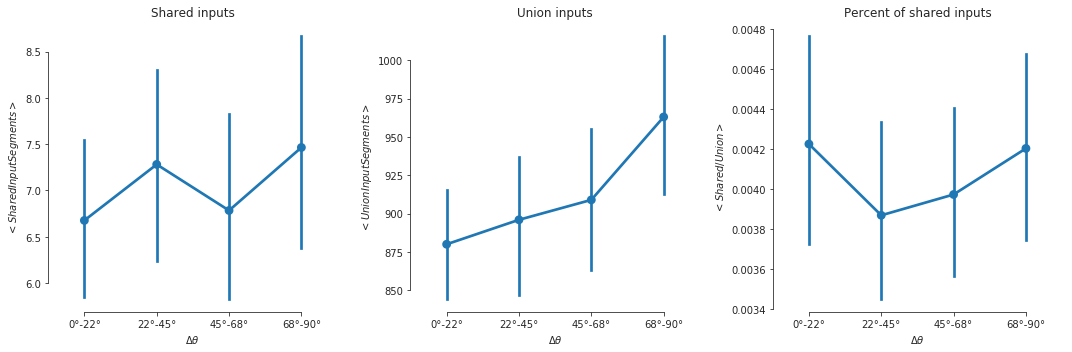

In [34]:
# for difference in preferred orientation 
radconn_df['percent_shared'] = radconn_df['n_seg_shared'] / radconn_df['n_seg_union']

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_pref_ori', 'n_seg_shared', data = radconn_df, ax=ax[0]) 
sns.pointplot('bin_diff_pref_ori', 'n_seg_union', data = radconn_df, ax=ax[1])  
sns.pointplot('bin_diff_pref_ori', 'percent_shared', data = radconn_df, ax=ax[2]) 
ax[0].set_title('Shared inputs')
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[0].set_xlabel(r'$\Delta \theta$')
ax[0].set_ylabel('$<Shared Input Segments>$')

ax[1].set_title('Union inputs')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[1].set_xlabel(r'$\Delta \theta$')
ax[1].set_ylabel('$<Union Input Segments>$')

ax[2].set_title('Percent of shared inputs')
ax[2].set_xticklabels(['{}°-{}°'.format(*a) for a in ori_labels])
ax[2].set_xlabel(r'$\Delta \theta$')
ax[2].set_ylabel('$<Shared / Union>$')

sns.despine(trim=True)
fig.tight_layout()



/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


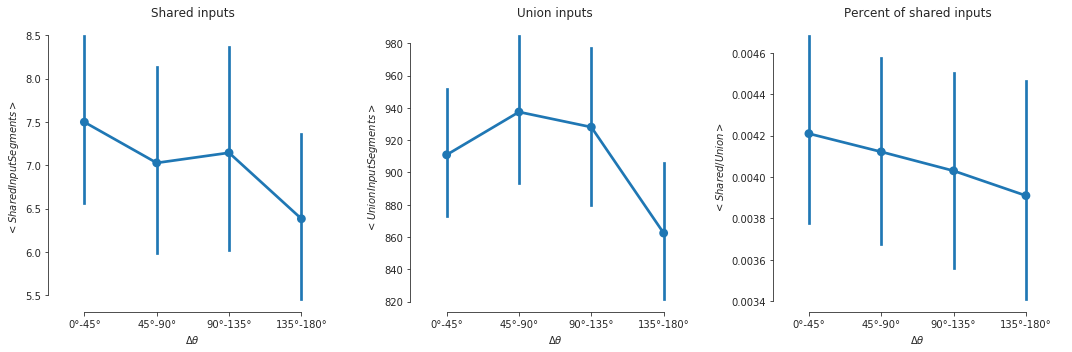

In [35]:
# for difference in preferred direction of motion 

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_pref_dir', 'n_seg_shared', data = radconn_df, ax=ax[0]) 
sns.pointplot('bin_diff_pref_dir', 'n_seg_union', data = radconn_df, ax=ax[1])  
sns.pointplot('bin_diff_pref_dir', 'percent_shared', data = radconn_df, ax=ax[2]) 
ax[0].set_title('Shared inputs')
ax[0].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[0].set_xlabel(r'$\Delta \theta$')
ax[0].set_ylabel('$<Shared Input Segments>$')

ax[1].set_title('Union inputs')
ax[1].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[1].set_xlabel(r'$\Delta \theta$')
ax[1].set_ylabel('$<Union Input Segments>$')

ax[2].set_title('Percent of shared inputs')
ax[2].set_xticklabels(['{}°-{}°'.format(*a) for a in dir_labels])
ax[2].set_xlabel(r'$\Delta \theta$')
ax[2].set_ylabel('$<Shared / Union>$')

sns.despine(trim=True)
fig.tight_layout()



/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


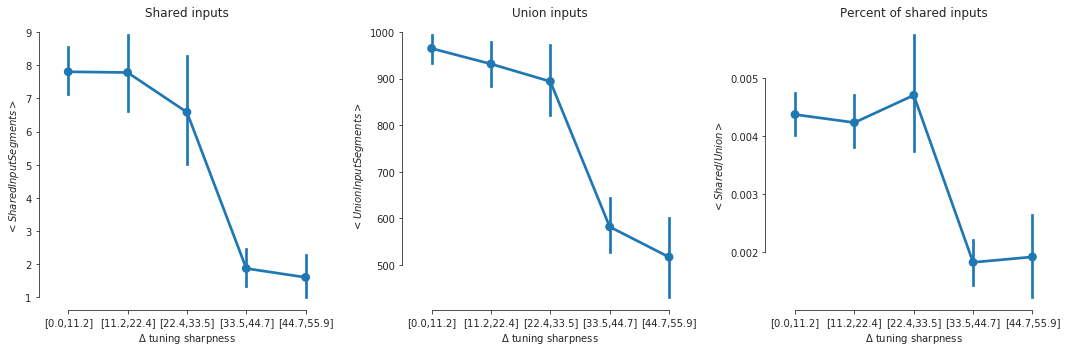

In [36]:
# for difference in tuning sharpness

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_diff_sharp', 'n_seg_shared', data = radconn_df, ax=ax[0]) 
sns.pointplot('bin_diff_sharp', 'n_seg_union', data = radconn_df, ax=ax[1])  
sns.pointplot('bin_diff_sharp', 'percent_shared', data = radconn_df, ax=ax[2]) 
ax[0].set_title('Shared inputs')
ax[0].set_xticklabels(['[{},{}]'.format(*a) for a in sharp_labels])
ax[0].set_xlabel(r'$\Delta$ tuning sharpness')
ax[0].set_ylabel('$<Shared Input Segments>$')

ax[1].set_title('Union inputs')
ax[1].set_xticklabels(['[{},{}]'.format(*a) for a in sharp_labels])
ax[1].set_xlabel(r'$\Delta$ tuning sharpness')
ax[1].set_ylabel('$<Union Input Segments>$')

ax[2].set_title('Percent of shared inputs')
ax[2].set_xticklabels(['[{},{}]'.format(*a) for a in sharp_labels])
ax[2].set_xlabel(r'$\Delta$ tuning sharpness')
ax[2].set_ylabel('$<Shared / Union>$')

sns.despine(trim=True)
fig.tight_layout()



## Receptive field

In [37]:
# functional metrics for each functional soma pair (restricting by spattune fitting significance)

sig_units = spattune.BestSTA.Loc & 'sta_snr > 1.5' & segment
sig_unit_pairs = (sig_units.proj(segment_id1 = 'segment_id') * 
                  sig_units.proj(segment_id2 = 'segment_id')) & 'segment_id1 < segment_id2'

attrs = ['n_syn_a', 'n_syn_b', 'n_syn_union', 'n_syn_shared', 'n_seg_a', 'n_seg_b', 'n_seg_union', 'n_seg_shared']
spatconn_df = pd.DataFrame(((spattune.BestSTACorr & sig_unit_pairs) * fc.SharedInput.proj(*attrs, segment_id1 = 'segment_id', segment_id2 = 'segment_b')).fetch())


In [38]:
# set up bins for `union_corr_r2`
union_edges = np.linspace(min(spatconn_df['union_corr_r2']), max(spatconn_df['union_corr_r2']), 6)
ue = list(['{:.2f}'.format(ee) for ee in union_edges])
union_labels = list(zip(ue[:-1], ue[1:]))
union_centers = np.hstack((np.nan, np.round((union_edges[1:] + union_edges[:-1])/2, decimals=2), np.nan))

In [39]:
# bin `union_corr_r2`
spatconn_df['bin_union_corr_r2'] = union_centers[(np.digitize(spatconn_df['union_corr_r2'], union_edges))]


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


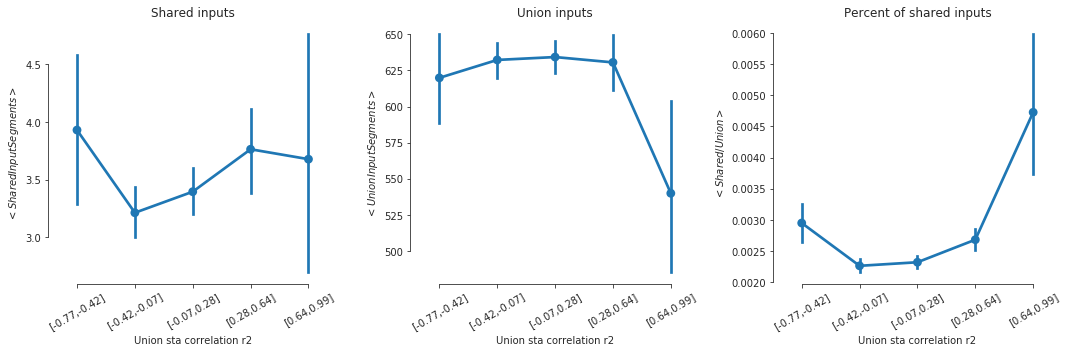

In [40]:
# for union_corr_r2 
spatconn_df['percent_shared'] = spatconn_df['n_seg_shared'] / spatconn_df['n_seg_union']
 
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot('bin_union_corr_r2', 'n_seg_shared', data = spatconn_df, ax=ax[0]) 
sns.pointplot('bin_union_corr_r2', 'n_seg_union', data = spatconn_df, ax=ax[1])  
sns.pointplot('bin_union_corr_r2', 'percent_shared', data = spatconn_df, ax=ax[2]) 
ax[0].set_title('Shared inputs')
ax[0].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[0].set_xlabel('Union sta correlation r2')
ax[0].set_ylabel('$<Shared Input Segments>$')

ax[1].set_title('Union inputs')
ax[1].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[1].set_xlabel('Union sta correlation r2')
ax[1].set_ylabel('$<Union Input Segments>$')

ax[2].set_title('Percent of shared inputs')
ax[2].set_xticklabels(['[{},{}]'.format(*a) for a in union_labels], rotation=30)
ax[2].set_xlabel('Union sta correlation r2')
ax[2].set_ylabel('$<Shared / Union>$')

sns.despine(trim=True)
fig.tight_layout()

